In [42]:
import random
import math
from time import sleep
from itertools import count
from collections import deque, namedtuple
from tqdm.notebook import trange, tqdm
import gym
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
to_tensor = lambda x: torch.tensor(x, device=dev)

In [43]:
env = gym.make("CartPole-v1")
env.reset()

array([ 0.02247142,  0.00836565, -0.03265321,  0.01168408], dtype=float32)

In [44]:
# Play
def play(policy, runs=50, wait=0):
    for _ in trange(runs):
        state = env.reset()
        for _ in count():
            state, reward, done, info = env.step(policy(state))
            env.render()

            if done:
                break
            sleep(wait)

In [45]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.queue = deque([], maxlen=capacity)
        
    def __len__(self):
        return len(self.queue)
        
    def push(self, *args):
        self.queue.append(Transition(*args))

    def sample(self, batchsize):
        return random.sample(self.queue, batchsize)

In [46]:
class DQN(nn.Module): # size(4) -> size(2)
    def __init__(self):
        super(DQN, self).__init__()
        self.l = nn.Sequential(
            nn.Linear(4, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2)
        )
        
    def forward(self, x):
        return self.l(x)


net = DQN().to(dev)
target_net = DQN().to(dev)
memory = ReplayMemory(10000)
target_net.load_state_dict(net.state_dict())

In [47]:
def optimize_model(memory, net, target_net, criterion, optim):
    # Update weights
    transition_batch = memory.sample(BS)

    states = to_tensor(np.array([batch[0] for batch in transition_batch]))
    next_states = to_tensor(np.array([batch[2] for batch in transition_batch]))
    future_q = target_net(next_states)
    
    Y = net(states)
    for i, (state, action, next_state, reward, done) in enumerate(transition_batch):
        reward = to_tensor(reward)
    
        y = reward if done else reward + gamma*torch.max(future_q[i])
        Y[i][action] = y

    for p in net.parameters():
        p.grad = None
    loss = criterion(Y, net(states))

    loss.backward()
    optim.step()
    return loss.item()

In [53]:
n_episodes = 200
gamma = 0.9
BS = 64
C = 5 # update target

losses = []
rewards = [0] * n_episodes

EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 50
get_eps = lambda steps_done: EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)

criterion = nn.MSELoss()
optim = torch.optim.RMSprop(net.parameters(), lr=1e-4, eps=.01)

steps_done = 0
target_count = 0
for episode in (tr := trange(n_episodes)):
#     env.render()
    state = to_tensor(env.reset())
    for t in count():
        tr.set_description(f'Step {t}')
        eps_threshold = get_eps(steps_done)
        steps_done += 1
        
        if np.random.uniform(0, 1) < eps_threshold:
            action = env.action_space.sample()
        else:
            action = torch.argmax(net(state)).item()
        next_state, reward, done, info = env.step(action)
        rewards[episode] += reward
        memory.push(state.cpu().numpy(), action, next_state, reward, done)

        if len(memory) >= BS:
            loss = optimize_model(memory, net, target_net, criterion, optim)
            losses.append(loss)
        state = to_tensor(next_state)
        if target_count >= C:
            target_net.load_state_dict(net.state_dict())
            target_count = 0
        else:
            target_count += 1
        if done:
            break

  0%|          | 0/200 [00:00<?, ?it/s]

0.00444903480965877

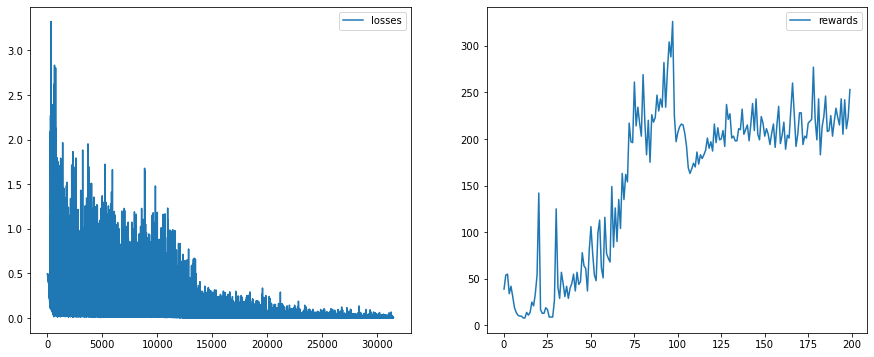

In [54]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(15, 6, forward=True)

axs[0].plot(losses, label='losses')
axs[1].plot(rewards, label='rewards')

[ax.legend() for ax in axs]
np.array(losses[-100:]).mean()

In [55]:
def policy(state):
     return torch.argmax(net(to_tensor(state))).item()
play(policy, runs=10, wait=0)

  0%|          | 0/10 [00:00<?, ?it/s]